In [2]:
import sys
print(sys.version) # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [3]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout
from tensorflow.keras.layers import Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

In [235]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde

from math import sqrt

In [5]:
print("Tensorflow version: ", tf.VERSION) # 1.13.1
print("Keras version: ", tf.keras.__version__) # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.13.1
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  False


# SmallerVGGNet, with noise layer added

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [6]:
filename = 'input_noise'

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

predict_only = True
predict_test_only = False

pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x))


In [7]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
        
        # add black & white noise to input data
        if chanDim == -1:
            noiseShape = (height, width, 1)
        else:
            noiseShape = (1, height, width)
            
        model.add(Dropout(0.2, noise_shape=noiseShape,
                          input_shape=inputShape)) # black
        model.add(Lambda(lambda x: 1 - x)) # 0 to 1, 1 to 0
        model.add(Dropout(0.1, noise_shape=noiseShape)) # white
        model.add(Lambda(lambda x: 1 - x))
        model.add(Activation("relu"))
           
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, name='learned_representation'))
        model.add(Activation("relu"))
        model.add(BatchNormalization(name='normalized_representation'))
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [8]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [9]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1

def _parse_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['norm_year']

def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

train_dataset = create_dataset(path_train_tfrecord)
test_dataset =  create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [10]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2],
)

for images,labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())
    
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Logits:  [[0.00243815]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 28, 28, 6)         0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 6)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 28, 6)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_______________________________________________________________

In [11]:
model.compile(optimizer='RMSprop', 
              loss='mean_squared_error')

Instructions for updating:
Use tf.cast instead.


In [12]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [13]:
def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [14]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [15]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

predictions = [x[0] for x in predictions]
# predictions

In [16]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

In [17]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [18]:
df = pd.DataFrame(zip(ids, true_year, predictions), columns=['ID', 'true_year', 'prediction'])
df['row'] = np.arange(len(df))
df

,ID,true_year,prediction,row
0,2829_105,0.520000,0.564108,0
1,999_37,0.360000,0.407199,1
2,7770_55A,0.200000,0.391869,2
3,2140_92B,0.520000,0.499879,3
4,509_73,0.500000,0.486079,4
5,19478_113,0.740000,0.749886,5
6,8657_70,0.360000,0.407565,6
7,1856_61,0.400000,0.460751,7
8,25606_107C,0.740000,0.726487,8
9,27502_140B,0.840000,0.779559,9


In [19]:
corr_year = df.true_year.corr(df.prediction)

r2_text = format(corr_year**2, '.3f')
r2_text = '$r^2 = ' + r2_text + '$'

if predict_test_only: 
    r2_text += '\n(Test dataset only)'
    
r2_text

'$r^2 = 0.891$'

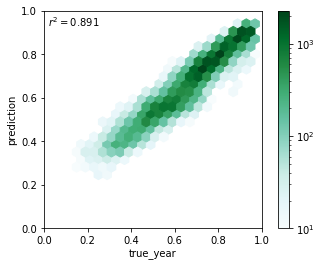

In [20]:
ax = df.plot.hexbin(x='true_year',y='prediction',
                    extent=(-0.03,1.01,-0.03,1.01), xlim=(0,1), ylim=(0,1), 
                    sharex=False, gridsize=26,
                    bins='log', mincnt=10,
                   )
ax.set_facecolor('w')
ax.set_aspect('equal')
ax.text(0.02,0.98,r2_text, verticalalignment='top')
fig = ax.get_figure()

if predict_test_only: 
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".pdf")
# fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".png")

In [21]:
# !cp /data/{filename}* .

In [22]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

layer_name = 'normalized_representation'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
intermediate_output = intermediate_layer_model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

intermediate_output.shape

(50540, 64)

In [23]:
X = pd.DataFrame(intermediate_output)
y_pred = df['prediction']
y_true = df['true_year']

In [24]:
print(X.shape, y_pred.shape)

(50540, 64) (50540,)


In [25]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,...,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,0.020839,-0.024505,0.012379,-0.025510,0.006238,0.022566,0.008364,0.002686,0.023153,0.005607,...,0.031705,-0.012075,0.019179,0.026192,0.040653,0.050561,0.007183,0.018600,0.037966,-0.009191
std,0.123312,0.150412,0.162176,0.130364,0.105160,0.103100,0.123142,0.080311,0.092586,0.098068,...,0.131762,0.125964,0.139509,0.118588,0.093751,0.144906,0.110065,0.111835,0.107644,0.131822
min,-0.291851,-0.252000,-0.351769,-0.320047,-0.079285,-0.192977,-0.223287,-0.080755,-0.330176,-0.251568,...,-0.048243,-0.093970,-0.123750,-0.119186,-0.097222,-0.325675,-3.270903,-0.068048,-0.246225,-0.161433
25%,-0.048196,-0.195403,-0.089282,-0.105002,-0.079285,-0.048529,-0.087933,-0.077326,-0.034912,-0.069140,...,-0.048243,-0.093970,-0.123750,-0.091004,-0.039223,-0.027934,-0.080299,-0.068048,-0.021542,-0.161208
50%,0.042384,0.029341,-0.007201,0.000890,-0.040113,0.055461,0.009391,-0.015804,0.026579,0.006171,...,-0.048243,-0.093970,0.017247,0.033480,0.048009,0.023748,0.024294,-0.025816,0.062744,-0.010092
75%,0.112337,0.095229,0.100221,0.073314,0.066383,0.104221,0.101100,0.052286,0.127944,0.069799,...,0.124581,0.066457,0.107800,0.104395,0.118811,0.093001,0.104016,0.066213,0.118183,0.090393
max,0.445732,0.422182,1.487275,0.298341,0.415100,0.206452,0.400385,0.364541,0.127944,0.208039,...,4.992395,4.244448,2.922475,2.231392,0.481714,3.208492,0.104016,0.620646,0.290536,2.311542


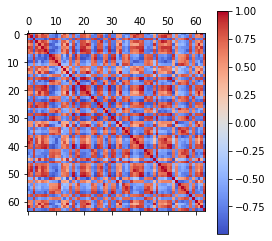

In [27]:
plt.matshow(X.corr(), cmap='coolwarm', norm=DivergingNorm(0)) # no white = high corr
plt.colorbar()
plt.show()

In [28]:
regr = LinearRegression().fit(X, y_pred)
print(regr.score(X, y_pred))
print(format(regr.score(X, y_true), '.3f'), format(corr_year**2, '.3f'))

0.9999999999902687
0.889 0.891


In [29]:
regr.coef_.shape

(64,)

In [30]:
regr.intercept_

0.69561034

In [31]:
n_factors = 7
ica = FastICA(n_components=n_factors, random_state=1106)
ica.fit(X)
X_ica = pd.DataFrame(ica.transform(X))

In [32]:
regr = LinearRegression().fit(X_ica, X)
print(regr.score(X_ica, X))

0.9571994494838754


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


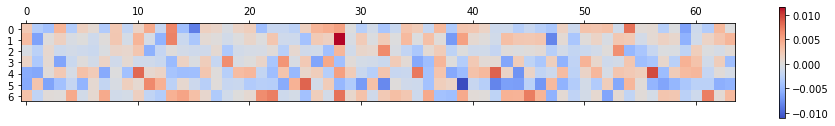

In [33]:
plt.matshow(ica.components_, cmap='coolwarm', norm=DivergingNorm(0)) # more white = less corr
plt.colorbar()
plt.show()

In [34]:
X_ica.describe()

,0,1,2,3,4,5,6
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
std,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448,0.004448
min,-0.025381,-0.013498,-0.223952,-0.018970,-0.030479,-0.026639,-0.010336
25%,-0.000511,-0.003531,-0.000777,-0.001900,-0.002216,-0.002657,-0.002602
50%,0.000855,-0.001314,0.000349,0.000501,0.000538,0.000062,-0.001171
75%,0.002303,0.004205,0.001491,0.002615,0.002922,0.002560,0.000867
max,0.040000,0.012907,0.011551,0.015953,0.014063,0.023319,0.030757


In [35]:
X_ica_1std = X_ica*sqrt(50539)
X_ica_1std = X_ica_1std.rename(lambda x: 'factor{}'.format(x), axis='columns')
X_ica_1std.describe()

,factor0,factor1,factor2,factor3,factor4,factor5,factor6
count,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000,50540.000000
mean,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000
std,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
min,-5.705941,-3.034492,-50.346343,-4.264653,-6.852005,-5.988603,-2.323644
25%,-0.114942,-0.793725,-0.174728,-0.427210,-0.498262,-0.597239,-0.584863
50%,0.192313,-0.295376,0.078519,0.112572,0.121012,0.013858,-0.263216
75%,0.517828,0.945226,0.335264,0.587945,0.656815,0.575403,0.194979
max,8.992337,2.901688,2.596841,3.586304,3.161377,5.242417,6.914369


In [36]:
df = df.join(pd.DataFrame(X_ica_1std))
df

,ID,true_year,prediction,row,factor0,factor1,factor2,factor3,factor4,factor5,factor6
0,2829_105,0.520000,0.564108,0,0.610861,1.784927,-0.387866,-0.324378,0.403469,-0.913536,0.172269
1,999_37,0.360000,0.407199,1,-2.765754,-0.138101,-0.334666,0.762627,0.294249,1.407909,-0.895094
2,7770_55A,0.200000,0.391869,2,-4.548736,0.465312,1.007582,-0.274205,-0.669356,-0.723154,0.420571
3,2140_92B,0.520000,0.499879,3,-0.828916,1.609499,0.455953,-0.605822,-0.177997,0.384288,0.330964
4,509_73,0.500000,0.486079,4,-0.538677,1.325498,-0.499484,0.783608,0.302330,-0.239858,-0.235724
5,19478_113,0.740000,0.749886,5,-0.054599,-0.498934,0.356266,-1.958823,0.826955,0.323624,0.010067
6,8657_70,0.360000,0.407565,6,-3.012241,0.229110,-0.303656,-0.009237,0.197173,0.447142,-0.187914
7,1856_61,0.400000,0.460751,7,-2.442365,0.646503,0.641678,-0.462992,0.314037,0.458152,-0.059180
8,25606_107C,0.740000,0.726487,8,0.198498,0.026068,0.414263,-0.265248,1.089119,-2.189572,-0.720863
9,27502_140B,0.840000,0.779559,9,0.512043,-0.255121,0.544485,-0.059453,-0.923944,-0.956275,-0.532626


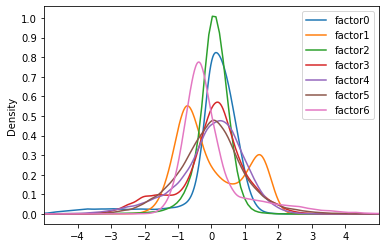

In [225]:
X_ica_1std.plot.kde(xlim=(-5, 5), xticks=range(-4,5), yticks=np.arange(0.,1.01,0.1))

In [93]:
percentile = X_ica_1std.quantile([0.001, 0.01, 0.99, 0.999])
display(percentile)
display(percentile.T.describe())

,factor0,factor1,factor2,factor3,factor4,factor5,factor6
0.001000,-4.917659,-2.104173,-13.126275,-3.333538,-4.138357,-3.254602,-1.714355
0.010000,-4.135029,-1.672716,-1.980192,-2.703205,-2.965200,-2.452662,-1.352591
0.990000,1.267658,1.957198,1.040878,2.131904,1.949563,2.679304,3.696343
0.999000,1.673199,2.207220,1.560112,2.835185,2.515110,3.900358,5.282300


,0.001,0.01,0.99,0.999
count,7.000000,7.000000,7.000000,7.000000
mean,-4.655565,-2.465942,2.103264,2.853355
std,3.893582,0.930617,0.889045,1.328750
min,-13.126275,-4.135029,1.040878,1.560112
25%,-4.528008,-2.834202,1.608611,1.940210
50%,-3.333538,-2.452662,1.957198,2.515110
75%,-2.679388,-1.826454,2.405604,3.367771
max,-1.714355,-1.352591,3.696343,5.282300


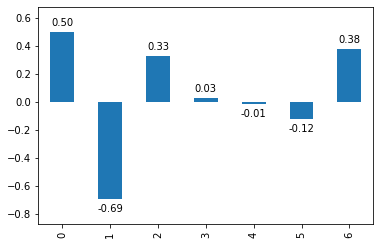

In [138]:
ax = X_ica.corrwith(y_pred).plot.bar()
ax.margins(y=0.15) 
bottom, top = ax.get_ylim()
yrange = top - bottom
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 0.02*yrange*(1 if p.get_height()>=0 else -1),
            format(p.get_height(), '.2f'),
            horizontalalignment='center', 
            verticalalignment='bottom' if p.get_height()>=0 else 'top')

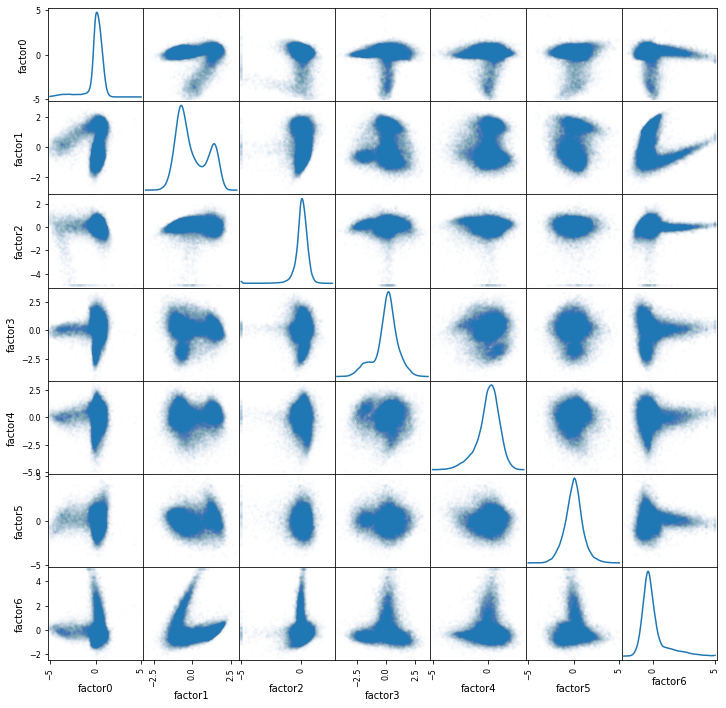

In [140]:
axs = scatter_matrix(X_ica_1std.clip(-5,5), alpha=0.01, figsize=(12, 12), diagonal='kde')

In [40]:
path_csv = "/data/fp_refined.csv"
df_csv = pd.read_csv(path_csv)
df_csv.columns

Index(['id_after', 'Path', 'index', 'APT_ID', 'Date', 'year', 'norm_year',
       'yyyymm', 'N_Housings', 'Max_Floors', 'Min_Floors', 'name', 'emd',
       'emd_name', 'sgg', 'sgg_name', 'sido', 'sido_name', 'sido_cluster',
       'sido_cluster_code', 'sido_sgg_name', 'FP_ID', 'Area', 'norm_log_area',
       'area_85', 'Entrance', 'Rooms', 'Baths', 'N_Units'],
      dtype='object')

In [41]:
if not 'N_Units' in df.columns:
    df = df.join(df_csv[['id_after', 'year',
                         'N_Housings', 'N_Units',
                         'Max_Floors', 'Min_Floors',
                         'sgg', 'sido_sgg_name', 'sido', 'sido_name',
                         'sido_cluster_code', 'sido_cluster',
                         'Area', 'norm_log_area', 'area_85',
                         'Entrance', 'Rooms', 'Baths', 
                        ]].set_index('id_after'), on='ID')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
true_year,50540.000000,0.700838,0.169370,0.000000,0.580000,0.720000,0.820000,1.000000
prediction,50540.000000,0.699696,0.152820,-1.194077,0.580846,0.730600,0.817622,0.975517
row,50540.000000,25269.500000,14589.785639,0.000000,12634.750000,25269.500000,37904.250000,50539.000000
factor0,50540.000000,-0.000000,1.000000,-5.705941,-0.114942,0.192313,0.517828,8.992337
factor1,50540.000000,0.000000,1.000000,-3.034492,-0.793725,-0.295376,0.945226,2.901688
factor2,50540.000000,0.000000,1.000000,-50.346343,-0.174728,0.078519,0.335264,2.596841
factor3,50540.000000,-0.000000,1.000000,-4.264653,-0.427210,0.112572,0.587945,3.586304
factor4,50540.000000,0.000000,1.000000,-6.852005,-0.498262,0.121012,0.656815,3.161377
factor5,50540.000000,0.000000,1.000000,-5.988603,-0.597239,0.013858,0.575403,5.242417
factor6,50540.000000,-0.000000,1.000000,-2.323644,-0.584863,-0.263216,0.194979,6.914369


In [42]:
# df.to_csv('/data/fp_ica.csv')

In [43]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

fps = []
for batch in iter:
    fps.extend(batch[0].numpy())

len(fps), fps[0][:,:,0].shape

(50540, (28, 28))

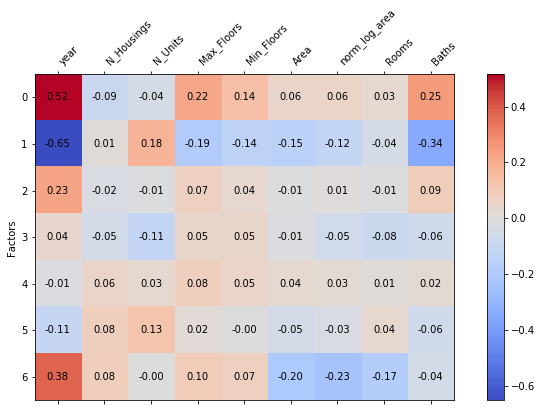

In [44]:
col_factors = ['factor{}'.format(i) for i in range(7)]
col_attributes = ['year',
                  'N_Housings', 'N_Units',
                  'Max_Floors', 'Min_Floors',
                  'Area', 'norm_log_area',
                  'Rooms', 'Baths']

# for factor in col_factors:
#     print(factor)
#     print(df[col_attributes].corrwith(df[factor]))
corr = df.corr()

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
im = ax.matshow(corr.loc[col_factors, col_attributes], cmap='coolwarm', norm=DivergingNorm(0))

fig.colorbar(im)

ax.set_ylabel('Factors')

ax.set_xticks(range(len(col_attributes)))
texts = ax.set_xticklabels(col_attributes)
[text.set_rotation(45) for text in texts]
[text.set_ha('left') for text in texts]

for (r, c), value in np.ndenumerate(corr.loc[col_factors, col_attributes]):
    ax.text(c, r, '{:0.2f}'.format(value), ha='center', va='center')

plt.show()

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]
(28, 28, 6)
(50540, 28, 28, 4)
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]


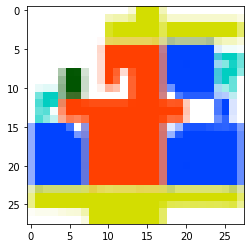

In [45]:
# adjusted for different luminance
channel_to_rgba = np.array(
    [[0., 0., 0., 1.], # unit mask to alpha
     [0., 0.33, 0., 0.], # entrance to green L30
     [1., 0.25, 0., 0.], # LDK to red L57
     [0., 0.26, 1., 0.], # bedroom to blue L40
     [0.83, 0.87, 0., 0.], # balcony to yellow L85
     [0., 0.81, 0.76, 0.]]) # bathroom to cyan L75

# make colors subtractive
channel_to_rgba[1:6, 0:3] -= 1

print(channel_to_rgba)
print(fps[0].shape)

# put it on transparent white
fps_rgba = np.array([1.,1.,1.,0.])+(np.array(fps) @ channel_to_rgba)
print(fps_rgba.shape)

np.set_printoptions(suppress=True)
print(np.amin(fps_rgba, axis=(1,2,3)))
print(np.amax(fps_rgba, axis=(1,2,3)))
fps_rgba = np.clip(fps_rgba, 0, 1)

fig = plt.figure()
ax = plt.imshow(fps_rgba[5])

In [226]:
df['weight'] = df.N_Units.clip(1, ) # at least 1 unit exists

sigma = [[-5, 5]] * 7

n_bins, n_samples = 40, 10
N = n_bins * n_samples

for f in range(n_factors):
    bin_f = 'bin{}'.format(f)
    df[bin_f] = pd.cut(df['factor{}'.format(f)].clip(*sigma[f]), n_bins, labels=False)

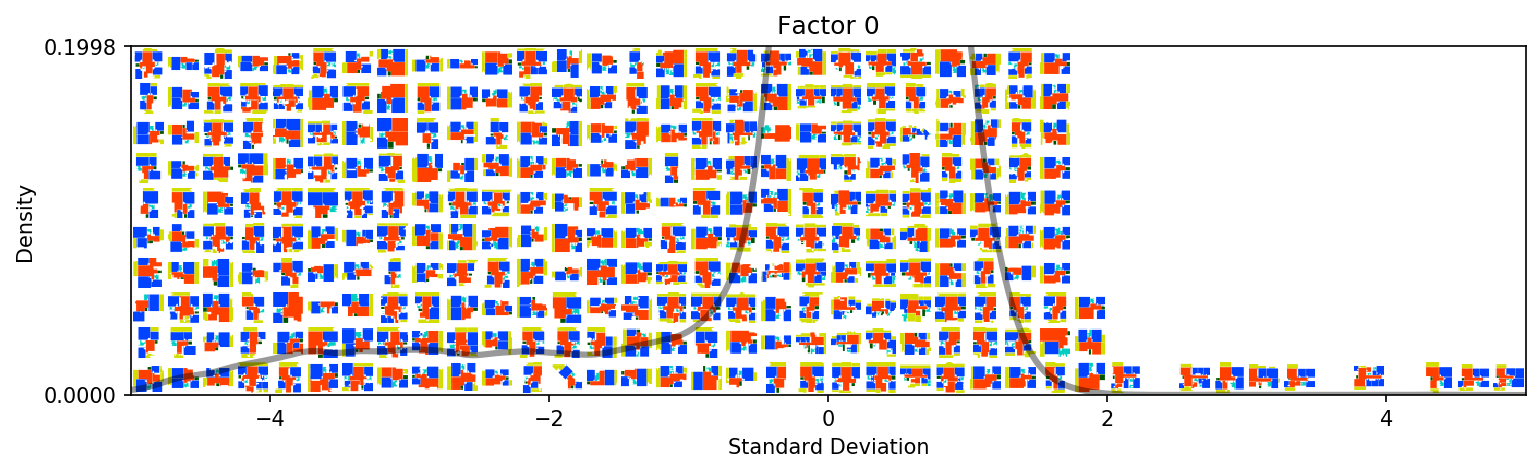

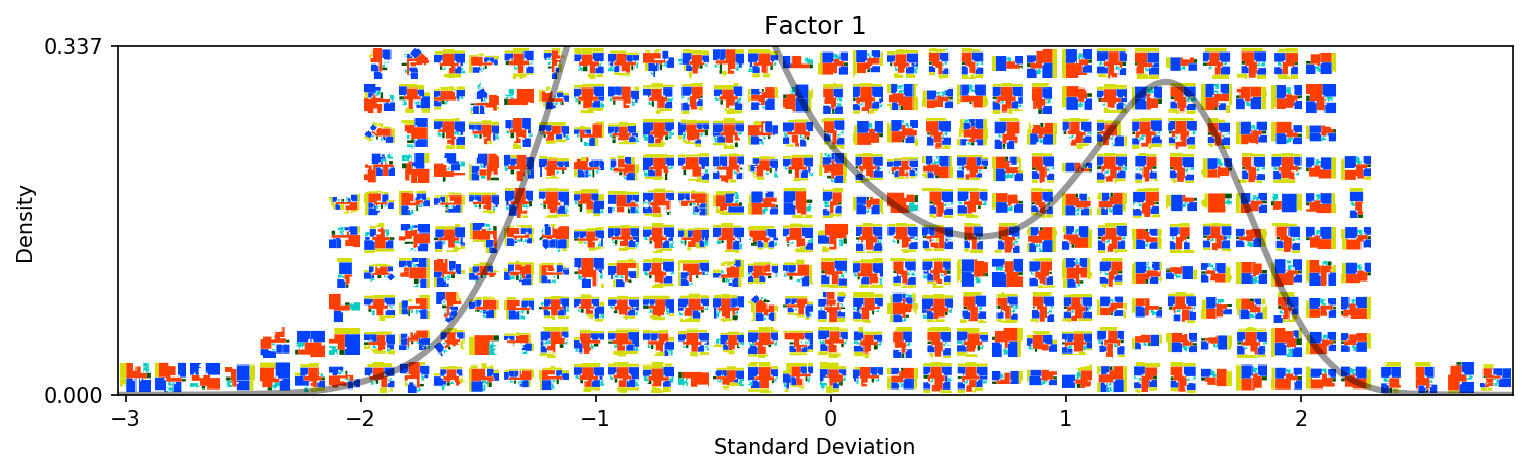

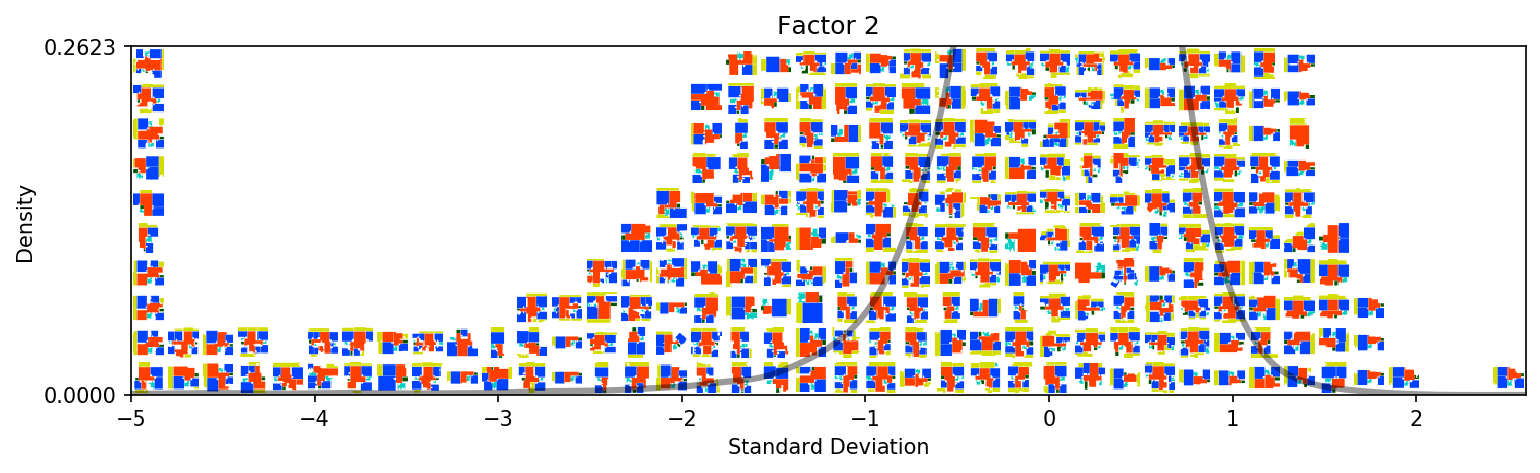

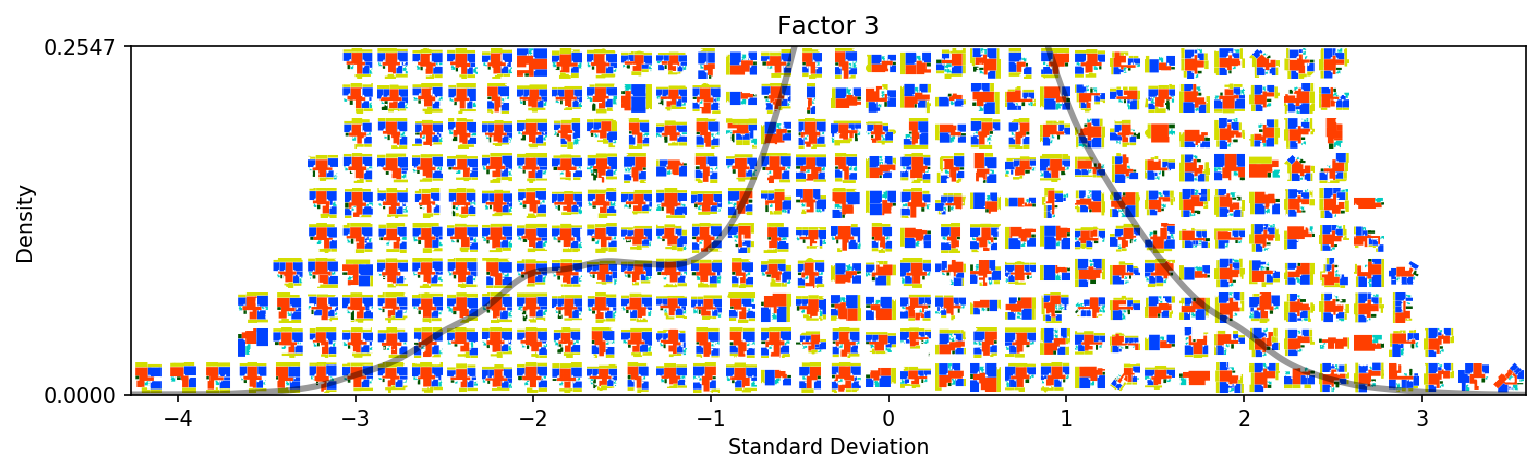

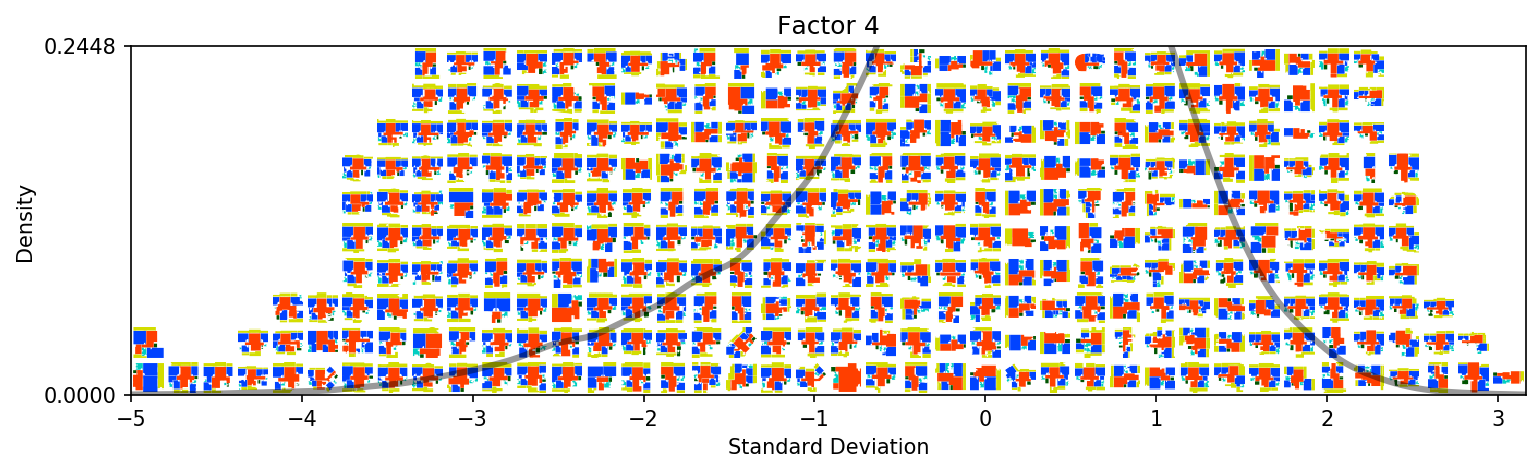

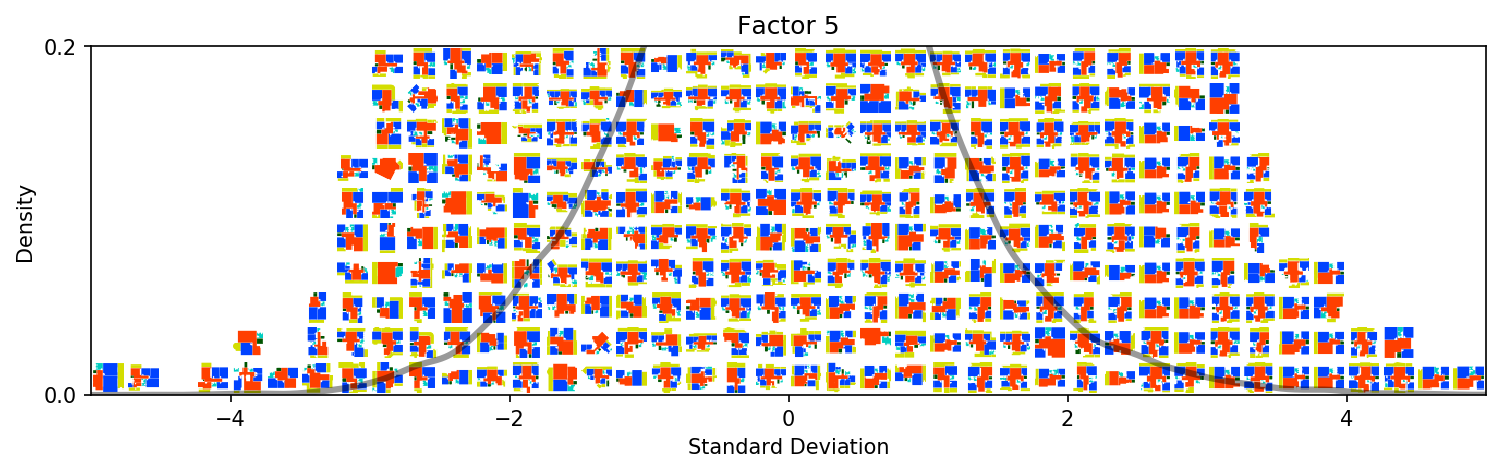

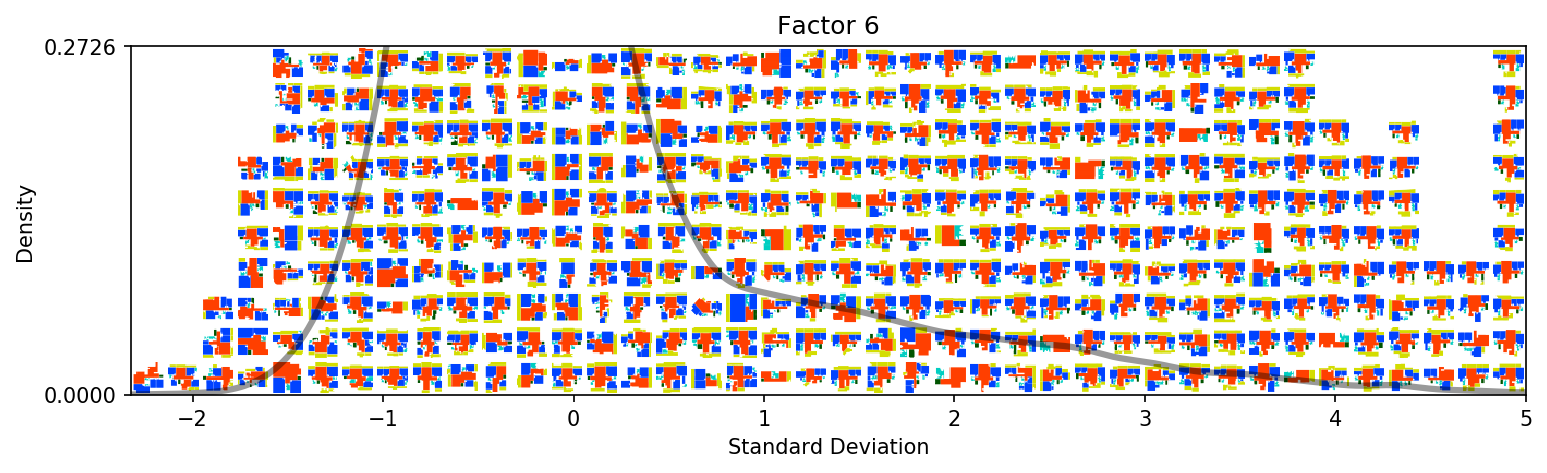

In [270]:
# stratified sample by standard deviation

border = 2
interval = 28 + border*2

fp_map = np.zeros((n_factors, n_samples*interval, n_bins*interval, 4)) # rc coord

sample = df.sample(N, weights='weight', random_state=1106)

for f in range(n_factors):
    bin_f = 'bin{}'.format(f)
    df[bin_f] = pd.cut(df['factor{}'.format(f)].clip(*sigma[f]), n_bins, labels=False)
    
    for c in range(n_bins):
        df_bin = df[df[bin_f] == c]
        
        if len(df_bin):
            sample = df_bin.sample(min(len(df_bin)//10 + 1, n_samples), weights='weight', random_state=1106)
            rows = sample.sort_values(by='factor{}'.format(f)).row

            for r in range(len(rows)):
                row = rows.iat[r]
                fp_map[f, 
                       r*interval+border:(r+1)*interval-border, 
                       c*interval+border:(c+1)*interval-border, 
                       :] = fps_rgba[row]

# fig, axs = plt.subplots(n_factors, 1, figsize=(36, 36))
for f in range(n_factors):
    fig = plt.figure(figsize=(12, 12), dpi=150)

    df_clipped = df['factor{}'.format(f)].clip(*sigma[f])
    xlim = [df_clipped.min(), df_clipped.max()]
    
    ax = fig.gca()
    
    kernel = gaussian_kde(df['factor{}'.format(f)])
    xs = np.arange(*xlim, (xlim[1]-xlim[0])/1000)
    ys = kernel(xs)
    ymax = ys.mean()*2
    
    ax.plot(xs, ys, color='k', linewidth=3, alpha=0.4)
#     ax.fill_between(xs, ys, color='k', alpha=0.1)
    
    ax.imshow(fp_map[f], aspect=((xlim[1]-xlim[0])/ymax)/(n_bins/n_samples), 
              origin='lower', extent=[*xlim, 0., ymax], zorder=0)

    ax.set_title('Factor {}'.format(f))
    ax.set_yticks(ax.get_ylim())
    ax.set_ylabel('Density')
    ax.set_xlabel('Standard Deviation')
    
    plt.show()
